# Creative Nation analysis

This notebook contains the core of the data analysis and exploration for Creative Nation


In [2027]:
%matplotlib inline

import mpld3
import matplotlib.patches as mpatches
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

frontier_data = ext_data+'/frontier'

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [2]:
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['year'] = year
    
    return(lqs)

## 1. Read data

### Metadata

In [3]:
#TTWA names, region lookups, information about whether a TTWA is a cluster or not

#Codes and names
ttwa_name_df = pd.read_csv(ext_data+'/ttwa_name_df.csv')

#Code - name lookup
ttwa_name_lookup = {x:y for x,y in zip(ttwa_name_df.ttwa_code, ttwa_name_df.ttwa_name)}

#Regions and info about whether they are a cluster
ttwa_region_df = pd.read_excel(ext_data+'/geography_of_creativity_data.xlsx',sheetname=0)

ttwa_region_lookup = {x:y for x,y in zip(ttwa_region_df.TTWA,ttwa_region_df.region)}
ttwa_region_lookup['Western Isles'] = 'Scotland'


ttwa_is_cluster = list(ttwa_region_df.loc[ttwa_region_df.creative_cluster=='yes','TTWA'])


### BRES

In [2049]:
#Load BRES data and extract LQs
bres_totals = pd.read_csv(ext_data+'/bres_creative_2015_16.csv')

#Columns to focus on
creative_subsector_lq_vars = list(bres_totals.columns[2:12])
creative_industries_lq_vars = list(bres_totals.columns[11:13])

bres_lqs_subsectoral = pd.concat([create_lq_df(
    bres_totals.loc[bres_totals.year==x,
                     ['ttwa_name']+creative_subsector_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2015,2016]])

bres_lqs_sectoral = pd.concat([create_lq_df(
    bres_totals.loc[bres_totals.year==x,
                     ['ttwa_name']+creative_industries_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2015,2016]])

### IDBR

In [827]:
#Load IDBR data and export sample (I know the contents of this)
idbr_totals = pd.read_csv(int_data+'/5_11_2017_idbr_totals.csv')
idbr_sizebands = pd.read_csv(int_data+'/5_11_2017_idbr_sizeband.csv')


idbr_all = pd.concat([idbr_totals,idbr_sizebands])

#Produce LQs
idbr_all_wide = pd.pivot_table(idbr_all,index=['year','ttwa_name'],columns='sector',values='value').reset_index(drop=False)

#We use the same format as before
idbr_lqs_subsectoral = pd.concat([create_lq_df(
    idbr_all_wide.loc[idbr_all_wide.year==x,
                     ['ttwa_name']+creative_subsector_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2016,2017]])

idbr_lqs_sectoral = pd.concat([create_lq_df(
    idbr_all_wide.loc[idbr_all_wide.year==x,
                     ['ttwa_name']+creative_industries_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2016,2017]])



## 2. Analysis [1] - Concentration and growth

**Question**

* What TTWAs have grown and what TTWAs have declined? 
* Are the CIs becoming more or less concentrated? In what regions? In what sectors?



In [6]:
#BRES changes
bres_changes = pd.pivot_table(pd.melt(bres_totals,id_vars=['ttwa_name','ttwa_code','year']).reset_index(drop=False),
               index=['ttwa_name','variable'],columns='year',values='value').reset_index(drop=False)

bres_changes['employment_change'] = bres_changes[2016]/bres_changes[2015]
bres_changes.rename(columns={2015:'emp_2015',2016:'emp_2016','variable':'sector'},inplace=True)


#IDBR changes
idbr_changes = pd.pivot_table(idbr_totals,index=['sector','ttwa_name'],columns='year',values='value').reset_index(drop=False)
idbr_changes['business_change'] = idbr_changes[2017]/idbr_changes[2016]

#NB we change years to the financial year the data refers to
idbr_changes.rename(columns={2016:'bc_2015',2017:'bc_2016'},inplace=True)

#Combine
all_changes = pd.concat([bres_changes.set_index(['ttwa_name','sector']),
                         idbr_changes.set_index(['ttwa_name','sector'])],axis=1).reset_index(drop=False)



In [7]:
#Need to replace the infinites
all_changes.replace([np.inf,-np.inf],np.nan,inplace=True)
all_changes_no_nas = all_changes.dropna()

all_changes_in_clusters = all_changes.loc[[x in ttwa_is_cluster for x in all_changes.ttwa_name],:]


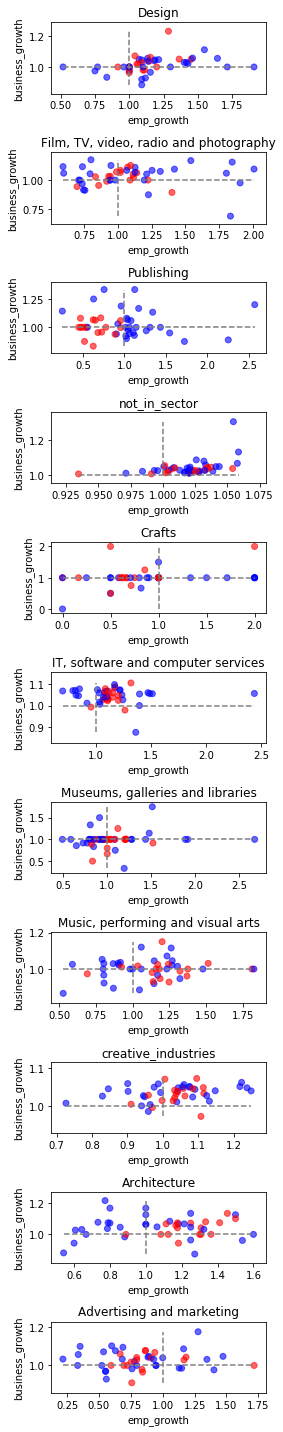

In [8]:
fig,ax =plt.subplots(nrows=len(set(all_changes.sector)),figsize=(4,20),
                    # sharex=True,
                    # sharey=True
                    )


for num,x in enumerate(set(all_changes_in_clusters.sector)):
    data = all_changes_in_clusters.loc[all_changes_in_clusters.sector==x,:]
    
    colors = ['red' if ttwa_region_lookup[x] in ['London','South East'] else 'blue' for x in data['ttwa_name']]
    
    
    scatter = ax[num].scatter(data['employment_change'],data['business_change'],alpha=0.6,
                   color=colors)
    
    ax[num].set_title(x)
    
    ax[num].hlines(y=1,xmin = data['employment_change'].min(),
                   xmax = data['employment_change'].max(),linestyles='dashed',color='grey')
    ax[num].vlines(x=1,ymin = np.nanmin(data['business_change']),
                   ymax = np.nanmax(data['business_change']),linestyles='dashed',color='grey')
    
    labels = list(data.ttwa_name)
    
    #tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    
    ax[num].set_xlabel('emp_growth')
    ax[num].set_ylabel('business_growth')


plt.tight_layout()

In [9]:
#This doesn't look very informative

In [10]:
#Growth
print(all_changes.loc[all_changes.sector=='creative_industries',['emp_2015','emp_2016']].sum())
print(all_changes.loc[all_changes.sector=='creative_industries',['bc_2015','bc_2016']].sum())

year
emp_2015    1260575.0
emp_2016    1344930.0
dtype: float64
year
bc_2015    280970
bc_2016    292840
dtype: int64


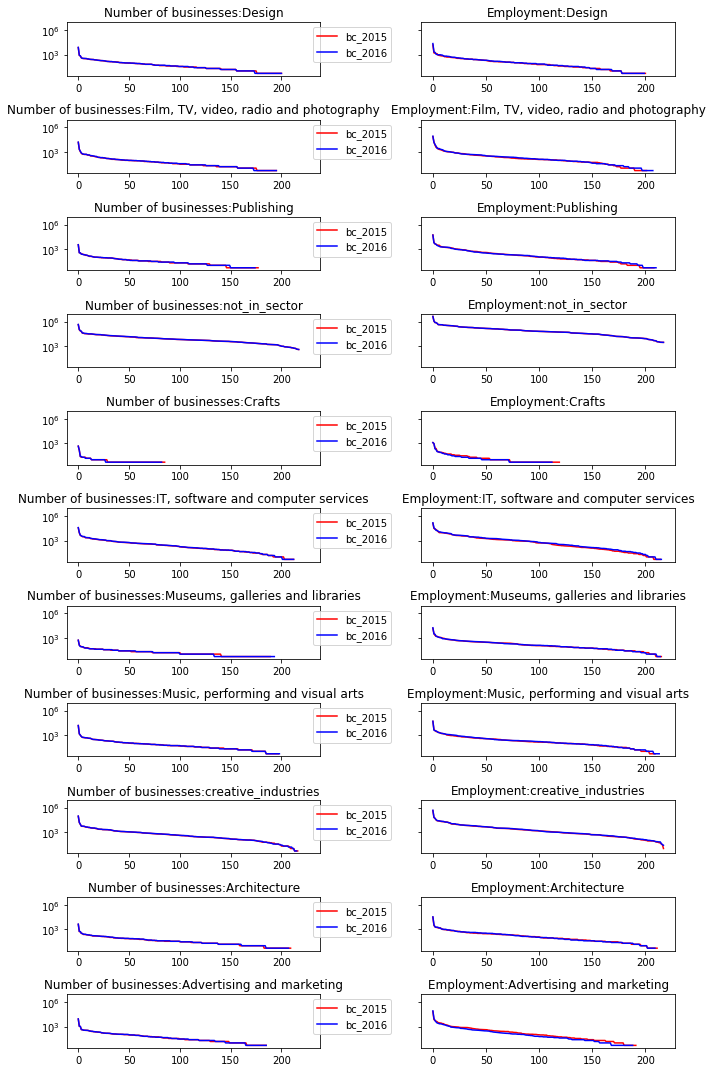

In [11]:
#What has happened in different sectors
sectors = set(all_changes.sector)

fig,ax = plt.subplots(ncols=2,nrows=len(sectors),figsize=(10,15),sharey=True)


for num,x in enumerate(sectors):
    sector_distr = all_changes.loc[
        all_changes.sector==x,['bc_2015','bc_2016','emp_2015','emp_2016']]
    
    ax[num][0].semilogy(np.arange(len(sector_distr)),
                        sector_distr['bc_2015'].sort_values(ascending=False),
                        color='red')
    ax[num][0].semilogy(np.arange(len(sector_distr)),
                        sector_distr['bc_2016'].sort_values(ascending=False),
                        color='blue')
    
    ax[num][0].legend(bbox_to_anchor=(1.3,1))

    ax[num][1].semilogy(np.arange(len(sector_distr)),
                        sector_distr['emp_2015'].sort_values(ascending=False),
                        color='red')
    ax[num][1].semilogy(np.arange(len(sector_distr)),
                        sector_distr['emp_2016'].sort_values(ascending=False),
                        color='blue')
    
    ax[num][0].set_title('Number of businesses:{x}'.format(x=x))
    ax[num][1].set_title('Employment:{x}'.format(x=x))

plt.tight_layout()
    

In [12]:
#Again not super informative

## Plot  concentration and concentration change

In [13]:
#Chart plotting share of activity by group

def extract_cumulatives(my_series,variable,my_breaks,sector):
    '''
    This function takes a variable and a list of breaks (rankings)
    It returns a table with the % of activity by group
    It also takes the sector name to label the series (it helps later when we concatenate variables)
    
    '''
    
    #Load my series, create shares and sort to get bigger TTWAs at the top
    ordered = my_series.dropna().sort_values(ascending=False).reset_index(drop=True)/my_series.sum()
    
    
    #Turn this into a dataframe
    ordered_df = ordered.reset_index(drop=False)
    
    #Bin into categories
    ordered_df['bins'] = pd.cut(ordered_df.index,my_breaks,include_lowest=True,right=False)
    
    #Aggregate over categories
    cumulative = ordered_df.groupby('bins')[variable].sum().cumsum()    
    cumulative.name=sector
    return(cumulative)

In [14]:
#####
#Data input
#####

#We focus on these breaks
my_breaks=[0,1,5,10,25,50,75,100,228]

#Data inputs for the chart
#Extract 2016 distributions of employment and business numbers for the top chart
distributions_16_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2016'],variable='emp_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors],axis=1)
#Business
distributions_16_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2016'],variable='bc_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors],axis=1)

#Extract 2015 distributions (which we will use to look at changes)
distributions_15_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2015'],variable='emp_2015',my_breaks=my_breaks,
                       sector=x) for x in sectors],axis=1)
#And business.
distributions_15_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2015'],variable='bc_2015',my_breaks=my_breaks,
                       sector=x) for x in sectors],axis=1)

#Changes

#We combine 2016-15 employments to extract changes in concentration
emp_conc_change = pd.concat([pd.melt(distributions_16_emp.reset_index(drop=False),id_vars='bins',value_name='emp_2016',
                                    var_name='variable_2016'),
           pd.melt(distributions_15_emp.reset_index(drop=False),id_vars='bins',value_name='emp_2015',
                  var_name='variable_2015')],axis=1)

emp_conc_change['change'] = 100*(emp_conc_change['emp_2016']/emp_conc_change['emp_2015']-1)

#Widen for plotting
emp_conc_wide = pd.pivot_table(emp_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2016',values='change')

#Same with the business counts
bc_conc_change = pd.concat([pd.melt(distributions_16_bc.reset_index(drop=False),
                                        id_vars='bins',value_name='bc_2016',
                                    var_name='variable_2016'),
           pd.melt(distributions_15_bc.reset_index(drop=False),id_vars='bins',value_name='bc_2015',
                  var_name='variable_2015')],axis=1)

bc_conc_change['change'] = 100*(bc_conc_change['bc_2016']/bc_conc_change['bc_2015']-1)

#And widen
bc_conc_wide = pd.pivot_table(bc_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2016',values='change')

In [15]:
#Labels for the X axis
conc_labels = ['Largest location','5 largest','10 largest ','25 largest','50 largest','75 largest','100 largest',
              'All']

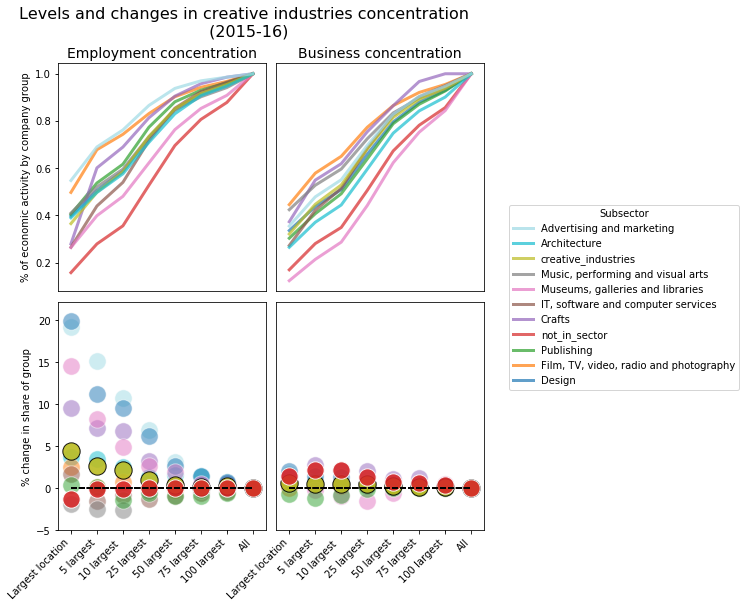

In [479]:
#####
#PLOT
#####

fig,ax = plt.subplots(figsize=(7,8),ncols=2,nrows=2,
                      sharex='col',
                      sharey='row')

#Plot employment concentrations
distributions_16_emp.plot(ax=ax[0][0],linewidth=3,alpha=0.7,colormap='tab20')
ax[0][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][0].set_xticks(np.arange(len(distributions_16_emp)))

#Titles
ax[0][0].set_title('Employment concentration',fontsize=14)
ax[0][0].set_ylabel('% of economic activity by company group')

#Remove the ticks for the x
ax[0][0].tick_params(axis='x', which='both', length=0)


#We will only use this legend. NN we displace it from its anchor so it's on the side, and
#we flip the order of the labels so that we have more concentrated categories at the top.

#This takes the handles and labels generated by matplotlib and allows us to modify them.
handles,labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(bbox_to_anchor=[3.3,0.4],handles=handles[::-1],labels=labels[::-1],title='Subsector')

#Plot the business distributions
distributions_16_bc.plot(ax=ax[0][1],linewidth=3,alpha=0.7,colormap='tab20')
ax[0][1].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][1].set_title('Business concentration',fontsize=14)
ax[0][1].set_xticks(np.arange(len(distributions_16_bc)))

#Remove all the ticks
ax[0][1].tick_params(axis='both', which='both', length=0)

#We make the legend invisible
ax[0][1].legend().set_visible(False)

#Get lines to label the colours below
lines = ax[0][1].get_lines()

#Create a lookup so we know what colour goes with every line. We then use it to colour the circles below.
lines_colors_lookup = {x.get_label():x.get_color() for x in lines}

#Draw the employment scatter
#Loop over every sector and draw it in the scatter
for x in np.arange(0,len(emp_conc_wide.columns)):
    
    #We have a lower alpha for the creative industries category (we want it to be more visible)
    ax[1][0].scatter(np.arange(len(emp_conc_wide)),emp_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[emp_conc_wide.columns[x]],
                     edgecolor='white' if emp_conc_wide.columns[x] !='creative_industries' else 'black',
                     s=300,alpha=0.5 if emp_conc_wide.columns[x] not in ['not_in_sector','creative_industries'] else 0.9)
    ax[1][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
    ax[1][0].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][0].set_ylabel('% change in share of group')
    ax[1][0].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_emp))],rotation=45,ha='right')

#Draw the business count scatter
for x in np.arange(len(emp_conc_wide.columns)):
    ax[1][1].scatter(np.arange(len(bc_conc_wide)),bc_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[bc_conc_wide.columns[x]],
                     edgecolor='white' if emp_conc_wide.columns[x] !='creative_industries' else 'black',
                     s=300,alpha=0.5 if emp_conc_wide.columns[x] not in ['creative_industries','not_in_sector'] else 0.9)
    ax[1][1].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][1].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_bc))],rotation=45,ha='right')
    
#Remove all the ticks
ax[1][1].tick_params(axis='y',which='both',length=0)

#Title above. NB the y we use to 
fig.suptitle('Levels and changes in creative industries concentration \n (2015-16)',y=1.05,fontsize=16)

#Tight layout 
plt.tight_layout()

#Adjust subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(fig_path+'/{today_str}_concentration.pdf'.format(today_str=today_str),bbox_inches='tight')

## Plot growth vs growth in other sectors

This is a bump chart with connecting growth in creative industries with growth in the rest of the economy
We use circles to indicate size of the sector (as a % of the economy)?

In [176]:
#Create a df with all the info we need for employment

#Drop all subsector info
growth_chart_emp = all_changes.loc[[x in ['creative_industries','not_in_sector'] for x in all_changes.sector],
                                  ['ttwa_name','sector','emp_2016','employment_change']].reset_index(drop=True)

#Pivot the data
growth_chart_emp = pd.concat([pd.pivot_table(
    growth_chart_emp,index='ttwa_name',columns='sector',values=x,) for x in ['employment_change','emp_2016']],
                             axis=1).dropna()
#Rename columns (currently we have repeated names)
growth_chart_emp.columns = ['creative_growth','other_growth','creative_emp','other_emp']

#Create a 'creative industries share of employment variable
growth_chart_emp['emp_share'] = growth_chart_emp['creative_emp']/(growth_chart_emp['other_emp']+growth_chart_emp['creative_emp'])

#Do the same with businesses

#Drop all subsector info
growth_chart_bc = all_changes.loc[[x in ['creative_industries','not_in_sector'] for x in all_changes.sector],
                                  ['ttwa_name','sector','bc_2016','business_change']].reset_index(drop=True)

#Pivot the data
growth_chart_bc = pd.concat([pd.pivot_table(
    growth_chart_bc,index='ttwa_name',columns='sector',values=x,) for x in ['business_change','bc_2016']],
                             axis=1).dropna()
#Rename columns (currently we have repeated names)
growth_chart_bc.columns = ['creative_growth','other_growth','creative_bc','other_bc']

#Create a 'creative industries share of employment variable
growth_chart_bc['bc_share'] = growth_chart_bc['creative_bc']/(growth_chart_bc['other_bc']+
                                                              growth_chart_bc['creative_bc'])


In [179]:
growth_comp = growth_chart_emp[['other_growth','creative_growth','emp_share']]
growth_bc = growth_chart_bc[['other_growth','creative_growth','bc_share']]

regions =list(set(ttwa_region_lookup.values()))

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(regions)))
regions_colors = {x:y for x,y in zip(regions,colors)}


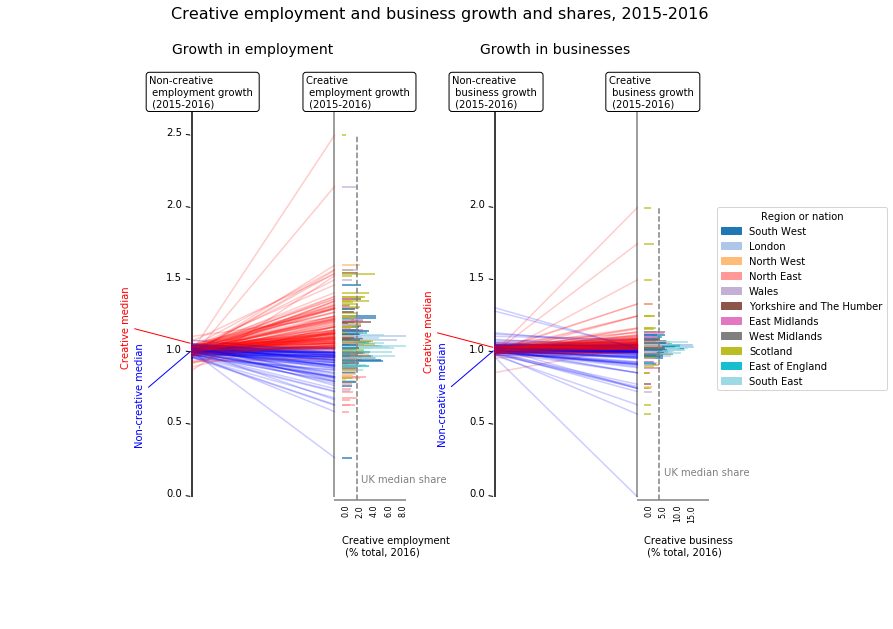

In [1842]:
#Initial plot

fig,ax = plt.subplots(figsize=(10,8),ncols=2)

for place in growth_comp.index:
    
    data = list(growth_comp.loc[place,['other_growth','creative_growth','emp_share']])

    ax[0].plot([0,1],[data[0],data[1]],alpha=0.2,
            #color=(data[1]-data[2]))
            color='red' if data[1]>data[0] else 'blue')
    
    ax[0].hlines(y=data[1],xmin=1.05,xmax=1.05+data[2]*5,edgecolor=regions_colors[ttwa_region_lookup[place]],
             alpha=0.9)
    
#Limits
ax[0].set_xlim(-1,1.5)
ax[0].set_ylim(-0.6,2.7)
ax[0].axis('off')    
    
#Vertical lines for axis
ax[0].vlines(x=0,ymax=3,ymin=0,color='black')
ax[0].vlines(x=1,ymax=3,ymin=0,color='grey')

#Y range
y_range = np.arange(np.round(growth_comp['creative_growth'].min()),np.ceil(growth_comp['creative_growth'].max())+0.5,0.5)

#Add x labels
for y in y_range:
    ax[0].annotate(s=y,xy=(0,y),xytext=(-0.18,y),arrowprops={'arrowstyle':'-','color':'black'})

#Lots of annotations for labels etc
ax[0].annotate(s='Non-creative median',
            xy=(0,np.median(growth_comp['other_growth'])),xytext=(-0.4,np.median(growth_comp['other_growth'])),
            color='blue',arrowprops={'arrowstyle':'-','color':'blue'},rotation=90)

ax[0].annotate(s='Non-creative \n employment growth \n (2015-2016)',
            xy=(-0.3,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[0].annotate(s='Creative \n employment growth \n (2015-2016)',
            xy=(0.8,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[0].annotate(s='Creative median',
            xy=(0,np.median(growth_comp['creative_growth'])),xytext=(-0.5,np.median(growth_comp['creative_growth'])+0.35),
            color='red',arrowprops={'arrowstyle':'-','color':'red'},rotation=90)

#Add the employment shares axis
ax[0].hlines(y=-0.02,xmin=1,xmax=10.5+growth_comp['emp_share'].max()*5,color='grey')

size_range = np.arange(1.05,1.05+growth_comp['emp_share'].max()*5,0.1)

for x in size_range:
    #print(x)
    #print(str(x/5))
    ax[0].annotate(str(100*(x-1.05)/5),xy=(x,-0.1),size=8,rotation=90)
    
#Add median share and annotate
ax[0].vlines(x=1.05+growth_comp['emp_share'].median()*5,ymin=-0.02,ymax=growth_comp['creative_growth'].max(),
            color='grey',linestyle='--')

#
ax[0].annotate(s='UK median share',xy=(1.08+growth_comp['emp_share'].median()*5,0.1),size=10,color='grey')


#Titles...
ax[0].annotate(s='Creative employment \n (% total, 2016)',xy=(1.05,-0.4),size=10)

ax[0].set_title('Growth in employment',y=1.1,x=0.57,fontsize=14)


patches = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

#Business plot

for place in growth_bc.index:
    
    data = list(growth_bc.loc[place,['other_growth','creative_growth','bc_share']])

    ax[1].plot([0,1],[data[0],data[1]],alpha=0.2,
            #color=(data[1]-data[2]))
            color='red' if data[1]>data[0] else 'blue')
    
    ax[1].hlines(y=data[1],xmin=1.05,xmax=1.05+data[2]*2,edgecolor=regions_colors[ttwa_region_lookup[place]],
             alpha=0.9)
    
#Limits
ax[1].set_xlim(-1,1.5)
ax[1].set_ylim(-0.6,2.7)
ax[1].axis('off')    
    
#Vertical lines for axis
ax[1].vlines(x=0,ymax=3,ymin=0,color='black')
ax[1].vlines(x=1,ymax=3,ymin=0,color='grey')

#Y range
y_range = np.arange(np.round(growth_bc['creative_growth'].min()),np.ceil(growth_bc['creative_growth'].max())+0.5,0.5)

#Add x labels
for y in y_range:
    ax[1].annotate(s=y,xy=(0,y),xytext=(-0.18,y),arrowprops={'arrowstyle':'-','color':'black'})

#Lots of annotations for labels etc
ax[1].annotate(s='Non-creative median',
            xy=(0,np.median(growth_bc['other_growth'])),xytext=(-0.4,np.median(growth_bc['other_growth'])),
            color='blue',arrowprops={'arrowstyle':'-','color':'blue'},rotation=90)

ax[1].annotate(s='Non-creative \n business growth \n (2015-2016)',
            xy=(-0.3,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[1].annotate(s='Creative \n business growth \n (2015-2016)',
            xy=(0.8,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[1].annotate(s='Creative median',
            xy=(0,np.median(growth_bc['creative_growth'])),xytext=(-0.5,np.median(growth_bc['creative_growth'])+0.35),
            color='red',arrowprops={'arrowstyle':'-','color':'red'},rotation=90)

#Add the employment shares axis
ax[1].hlines(y=-0.02,xmin=1,xmax=10.5+growth_bc['bc_share'].max()*2,color='grey')

size_range = np.arange(1.05,1.05+growth_bc['bc_share'].max()*2,0.1)

for x in size_range:
    ax[1].annotate(str(100*(x-1.05)/2),xy=(x,-0.1),size=8,rotation=90)

ax[1].annotate(s='Creative business \n (% total, 2016)',xy=(1.05,-0.4),size=10)

ax[1].set_title('Growth in businesses',y=1.1,x=0.57,fontsize=14)


patches = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

ax[1].legend(handles=patches,
             bbox_to_anchor=(1.01,0.8),
             title='Region or nation')

#Add median share and annotate
ax[1].vlines(x=1.05+growth_bc['bc_share'].median()*2,ymin=-0.02,ymax=growth_bc['creative_growth'].max(),
            color='grey',linestyle='--')

#
ax[1].annotate(s='UK median share',xy=(1.08+growth_bc['bc_share'].median()*2,0.15),size=10,color='grey')

#legend_2 = ax[1].legend(labels=['growth','no_growth'],bbox_to_anchor=(1.01,0.4))

#ax[1].add_artist(legend_1)
#ax[1].add_artist(legend_2)

plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=-0.15)
plt.suptitle('Creative employment and business growth and shares, 2015-2016',y=1.05,x=0.6,size=16)

patches_reg = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

labels_reg = regions

plt.savefig(fig_path+'/{date_today}_growth_creative_other.pdf'.format(date_today=today_str),bbox_inches='tight')



## Plot subsectoral changes

In [500]:
#This could simply be a violinplot with grouped by region?
#Add a region to each variable
all_changes['region'] = [ttwa_region_lookup[x] for x in all_changes['ttwa_name']]
all_changes['emp_total'] = all_changes['emp_2016'] - all_changes['emp_2015'] 
all_changes['bc_total'] = all_changes['bc_2016'] - all_changes['bc_2015'] 

regions = set(ttwa_region_lookup.values())- set(['Northern Ireland'])

regions_sorted = list(reversed(all_changes.loc[
    all_changes.sector=='creative_industries',:].groupby(
    'region')['emp_total'].sum().sort_values(ascending=False).dropna().index))

sectors_sorted = all_changes.groupby('sector')['emp_2016'].sum().sort_values(ascending=False).dropna().index[1:]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


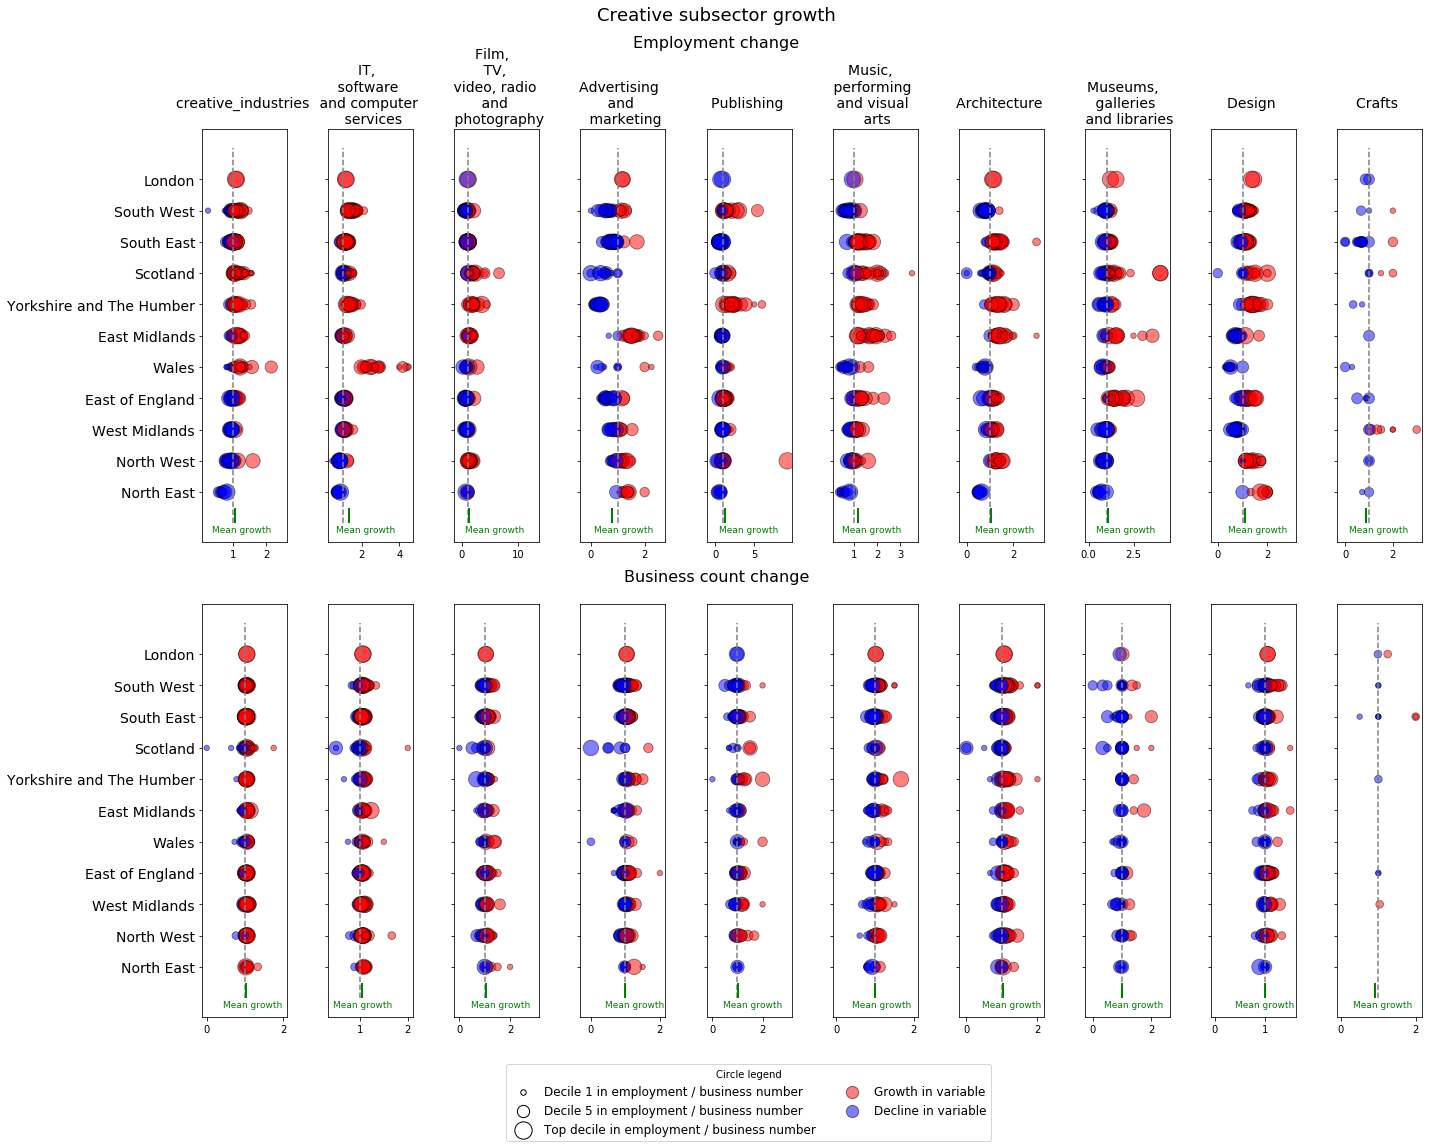

In [593]:
#The columns are a sector
#sectors_sorted = [x for x in sectors_sorted if x!='Crafts']


#Create plot
fig,ax = plt.subplots(ncols=len(sectors_sorted),nrows=2,figsize=(20,14),sharey='row',
                      #sharex='col'
                     )

#Loop over sectors to subset
for num,x in enumerate(sectors_sorted):
    
    #Get data for the sector
    sector_data = all_changes.loc[all_changes.sector==x,:]
    
    #Convert the data into a collection of vectors for each region
    
    #1. Employment
    data_rate = [list(sector_data.loc[sector_data.region==reg,'employment_change'].dropna()) for reg in regions_sorted]
    data_total = [list(sector_data.loc[sector_data.region==reg,'emp_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe (we use these for the circle sizes)
    sector_data['quantised']= pd.qcut(sector_data.loc[:,'emp_2016'],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Now we produce the same vectors as before but with the quantiles
    data_quant = [list(sector_data.loc[sector_data.region==reg,'quantised'].dropna()) for reg in regions_sorted]
    
    #2. Business counts
    data_rate_bc = [list(sector_data.loc[sector_data.region==reg,'business_change'].dropna()) for reg in regions_sorted]
    data_total_bc = [list(sector_data.loc[sector_data.region==reg,'bc_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe
    sector_data['quantised_bc']= pd.qcut(sector_data.loc[:,'bc_2016'],
                                         q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Extract the deciles for each region
    data_quant_bc = [list(sector_data.loc[sector_data.region==reg,'quantised_bc'].dropna()) for reg in regions_sorted]
    
    #This loops over each region to subset its data and produce the scatter.
    for num_2 in np.arange(len(regions_sorted)):
        
        #This tells us how many points to use in the scatter (as many as there are TTWAs)
        tot = len(data_rate[num_2])
        
        #Draw the employment info in the top scatter
        ax[0][num].scatter(y=[num_2]*tot,
                        x=data_rate[num_2],
                        s=[x*30 for x in data_quant[num_2]],
                        alpha=0.5,
                        edgecolor='black',
                        linewidth=0.8,
                        c=['red' if x >1 else 'blue' for x in data_rate[num_2]])
        
        #Draw the business info inthe second scatter
        tot_2 = len(data_rate_bc[num_2])
        ax[1][num].scatter(y=[num_2]*tot_2,
                           x=data_rate_bc[num_2],
                           s=[x*30 for x in data_quant_bc[num_2]],
                           alpha=0.5,
                           edgecolor='black',
                           linewidth=0.8,
                           c=['red' if x >1 else 'blue' for x in data_rate_bc[num_2]])
    
    #We want to add chart titles that include a line break after a certain length
    sector_name = []
    
    split=x.split(" ")
    
    #If the number of words is above 3 it in
    split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    if '\n' not in split_rejoined:
        split_rejoined+=' \n'
    
    #Add all the titles and ticks
    ax[0][num].set_title(split_rejoined,size=14)
    ax[0][num].set_yticks(np.arange(len(regions_sorted)))
    ax[0][num].set_yticklabels(regions_sorted,size=14)
    
    #Add a vline to separate growth and decline
    ax[0][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Add a green line with mean growth for the sector
    ax[0][num].vlines(x=sector_data.loc[:,'employment_change'].dropna().mean(),
                     ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[0][num].annotate('Mean growth',xy=(sector_data.loc[:,'employment_change'].dropna().mean()-0.7,
                                          -1.3),color='green',size=9)
                       
    #Titles and ticks for the business count plots
    ax[1][num].set_yticks(np.arange(len(regions_sorted)))
    ax[1][num].set_yticklabels(regions_sorted,size=14)
    ax[1][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Mean growth for businesses 
    ax[1][num].vlines(x=sector_data.loc[:,'business_change'].dropna().mean(),
                      ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[1][num].annotate('Mean growth',xy=(sector_data.loc[:,'business_change'].dropna().mean()-0.6,
                                          -1.3),color='green',size=9)
    
    #Add custom legend with some invisible scatters
    d1 = plt.scatter([],[], s=30, marker='o',color='white',edgecolor='black')
    d5 = plt.scatter([],[], s=150, marker='o',color='white',edgecolor='black')
    d10 = plt.scatter([],[], s=300, marker='o',color='white',edgecolor='black')
    pg = plt.scatter([],[], s=150, marker='o',color='red',edgecolor='black',alpha=0.5)
    ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
    plt.legend((d1,d5,d10,pg,ng),
               ('Decile 1 in employment / business number', 
                'Decile 5 in employment / business number', 
                'Top decile in employment / business number',
               'Growth in variable','Decline in variable'),
               scatterpoints=1,
               title='Circle legend',
               bbox_to_anchor=(
                   -4,
                   -0.1),
               ncol=2,
               fontsize=12)    
    
#Add subplot row titles
plt.figtext(x=0.5,y=0.99,s='Employment change',size=16,ha='center')
plt.figtext(x=0.5,y=0.46,s='Business count change',size=16,ha='center')

#Layout
plt.tight_layout()

#Adjust subplots to create some space for the row titles
plt.subplots_adjust(hspace=0.15)

#Figure title
fig.suptitle('Creative subsector growth',y=1.03,size=18)

#Plot
plt.savefig(fig_path+'/{date}_subsector_change.pdf'.format(date=today_str),bbox_inches='tight')

## Neighbour dynamics

Idea: for each TTWA, find its neighbours and average their performance (could be growth or concentration,
by sector or something else). Then correlate its performance with theirs.



In [1579]:
#Import python for spatial analysis library
import pysal
from scipy.stats import linregress
import geopandas as gp
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

#Create lookup of ttwas
ttwa_names_to_codes_lookup = {v:k for k,v in ttwa_name_lookup.items()}

#This excludes NI TTWAs
all_changes_no_nas['ttwa_code'] =[ttwa_names_to_codes_lookup[x] for x in all_changes_no_nas['ttwa_name']]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1420]:
#Get Shapefile here:
#https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip

#Load shapefile
shapefile_loc = ext_data+'/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3'

ttwa_shp = pysal.open(shapefile_loc+'/TTWA_2011_UK_BGC_V3.shp')

#Read shapefile weights and attributes
#And attributes
w = pysal.rook_from_shapefile(shapefile_loc+"/TTWA_2011_UK_BGC_V3.shp")
attr = pysal.open(shapefile_loc+"/TTWA_2011_UK_BGC_V3.dbf")

#Remove from data those ttwas with missing values

#Merge with shapefile attributes for ordering
changes_ord = pd.merge(pd.DataFrame(attr.by_col['TTWA11CD'],columns=['TTWA11CD']),
                   ttwas_coded,left_on='TTWA11CD',right_on='ttwa_code',how='outer',sort=False)

#Create df with only complete TTWAS and remove those from the weights
changes_ord_completes = changes_ord[[str(x)!="nan" for x in changes_ord.ttwa_code]]
ttwas_w_data = list(changes_ord_completes.index)

#Subset weights to focus on available TTWAs, and normalise
wsub = pysal.w_subset(w,ttwas_w_data)
wsub.transform='r'

('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 9, 166, 167, 168, 169
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [828]:
#Ideas
#Simple analysis:

#For each sector and area:
    #Take their neighbors and extract their average growth and concentration (to draw a scatter)
    #Take the growth and concentration of their neighbours (to draw a heatmap)


#Lookup between shapefiles indices and TTWAs
ttwa_index_name_lookup = {x:y for x,y in zip(changes_ord_completes.index,changes_ord_completes.ttwa_name)}

#Dict with the neighbours for each area
neighbors_looked_up = {ttwa_index_name_lookup[x]:
                       [ttwa_index_name_lookup[item] for item in y] for x,y in wsub.neighbors.items()} 

#Some additional data processing to obtain the LQs by sector / area / year and their change

bres_lqs = pd.pivot_table(pd.melt(pd.concat(
    [bres_lqs_sectoral.set_index('year',append=True),bres_lqs_subsectoral.set_index('year',append=True)],
    axis=1).reset_index(drop=False),id_vars=['ttwa_name','year'],var_name='sector',value_name='emp_lq'),
                          index=['ttwa_name','sector'],columns='year',values='emp_lq').reset_index(drop=False)

bres_lqs.rename(columns={2016:'emp_lq_2016',2015:'emp_lq_2015'},inplace=True)

bres_lqs['emp_lq_change'] = bres_lqs['emp_lq_2016']/ bres_lqs['emp_lq_2015']

#IDBR

idbr_lqs = pd.pivot_table(pd.melt(pd.concat(
    [idbr_lqs_sectoral.set_index('year',append=True),idbr_lqs_subsectoral.set_index('year',append=True)],
    axis=1).reset_index(drop=False),id_vars=['ttwa_name','year'],var_name='sector',value_name='bc_lq'),
                          index=['ttwa_name','sector'],columns='year',values='bc_lq').reset_index(drop=False)

idbr_lqs.rename(columns={2017:'bc_lq_2016',2016:'bc_lq_2015'},inplace=True)

idbr_lqs['bc_lq_change'] = idbr_lqs['bc_lq_2016']/ idbr_lqs['bc_lq_2015']


In [1233]:
#Combine all lqs
all_lqs = pd.concat([bres_lqs.set_index(['ttwa_name','sector']),
                   idbr_lqs.set_index(['ttwa_name','sector'])],axis=1)

#Combine everything
all_data = pd.concat([all_changes.set_index(['ttwa_name','sector']),all_lqs],axis=1)

#Create another couple of variables we will use later
all_data['emp_growth'] = all_data['emp_2016']-all_data['emp_2015']

all_data['bc_growth'] = all_data['bc_2016']-all_data['bc_2015']

#Add regions
all_data['region'] = [ttwa_region_lookup[x] for x in all_data.reset_index(drop=False)['ttwa_name']]

In [1234]:
#Function to extract neighbour stats
def get_neighbour_stats(df,sector,var):
    '''
    This function loops over each TTWA and estimates the mean scores of its neighbours in a variable (for a sector)
    It returns a dataframe with the means and a matrix combining their scores
    
    '''
    
    #Is it employment or bc?
    
    if var=='emp':
        var_1 = 'emp_lq_change'
        var_2 = 'emp_growth'
    else:
        var_1 = 'bc_lq_change'
        var_2 = 'bc_growth'
    
    
    #First step: subset by sector
    df_sector = df.loc[df.sector==sector,:]
    
    #Create a container
    cont = []
    mat = []
    #Second step: 
    #For each TTWA, subset by the neighbors and calculate averages.
    for x in df_sector['ttwa_name']:
        
        #Area's own score
        own_score = float(df_sector.loc[df_sector.ttwa_name==x,var_1])
        
        #Extract neighbours
        try:
            neighs = neighbors_looked_up[x]
    
            #Subset variable to get neighbours
            neighbours = df_sector.loc[[x in neighs for x in df_sector['ttwa_name']],['ttwa_name',var_1]]
            
            #Calculate mean
            value = neighbours[var_1].dropna().mean()
            
            #Create new DF with all the neighbour info
            neighbours_2 = neighbours.set_index('ttwa_name')
            
            #Name the neighbours and transpose for concatenating on rows
            neighbours_2.columns=[x]
            neighbours_2 = neighbours_2.T
            
            #Create series
            out = pd.Series({'ttwa_name':x,'neighs':", ".join(neighs),'{n}_neighbor'.format(n=var):value,
                           '{n}_own'.format(n=var):own_score})
            
            mat.append(neighbours_2)

            
        except:
            out = pd.Series({'ttwa_name':x,'neighs':np.nan,'{n}_neighbor'.format(n=var):np.nan,
                           '{n}_own'.format(n=var):own_score})
        
        
        cont.append(out)


    
    #Out simple
    out_df = pd.DataFrame(cont).reset_index(drop=True)    
    
    #Add quantised data
    df_sector['{var}_growth_q'.format(var=var)] = pd.qcut(
        df_sector[var_2],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop') 
    
    
    #Out matrix
    out_mat = pd.concat(mat)
    
    return([pd.concat([out_df.set_index('ttwa_name'),
                       df_sector.set_index('ttwa_name')],axis=1)])
        


In [1628]:
#Create data for scatters as a lookup
data_for_scatters = {x:get_neighbour_stats(all_data.reset_index(drop=False),x,'emp')[0] for x in
                sectors_sorted}

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3438]:
ttwa_shp_read = gp.read_file(shapefile_loc)

#Create merged TTWA
ttwa_merged = pd.merge(ttwa_shp_read,
                       all_changes.loc[
                           all_changes.region!='Northern Ireland',
                           ['ttwa_name','employment_change','emp_2016','sector']],left_on='TTWA11NM',right_on='ttwa_name')

In [2061]:
def map_sector(sector,ax,df=ttwa_merged,neighbor_lookup=data_for_scatters,my_cmap='RdBu_r'):
    '''
    This function takes a sector and plots it, together with the scatter showing area / neighbour performance
    
    '''
    
    #Subset
    map_data = ttwa_merged.loc[ttwa_merged.sector==sector,:]
    
    #Quantise the employment change df
    map_data['employment_change_q']= pd.qcut(map_data['employment_change'],
                                           q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    
    #Plot map
    map_data.plot(column='employment_change_q',
              ax=ax,cmap=my_cmap)
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    #Add title (inserting breaks if needed)
    
    #split=sector.split(" ")
    
    #If the number of words is above 3 it in
    #split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    #if '\n' not in split_rejoined:
    #    split_rejoined+=' \n'
    
    ax.set_title(sector,y=1.01,size=12)

    
    # Manually set the position and relative size of the inset axes within ax1
    ax2 = inset_axes(ax,
                     width='30%',  # width = 10% of parent_bbox width
                     height=1,  # height : 50%
                     #loc=1,bbox_to_anchor=(0,0,1,1)
                     loc=7
                    )

    
    #Other data
    scatter_data = neighbor_lookup[sector]
    
    #Remove infinites for the linear regression analysis
    lr_data = scatter_data[['emp_neighbor','emp_own']].replace([np.inf, -np.inf], np.nan)
    lr_data.dropna(inplace=True)
    
    #Regress
    linres = linregress(lr_data.iloc[:,0],lr_data.iloc[:,1])
    
    #Plot
    ax2.plot(
        #Exes
        [lr_data['emp_neighbor'].min(),
        lr_data['emp_neighbor'].max()],        
        
        #Ys (including intercept and regression coefficient)
        [lr_data['emp_own'].min()+linres[1],
         lr_data['emp_own'].max()*linres[0]],
        
        #Styles
        color='black',linestyle='--',linewidth=1)
    
    #Add x & y vlines
    ax2.vlines(x=1,
                   ymin=lr_data['emp_own'].min(),
                   ymax=lr_data['emp_own'].max(),color='grey',linestyle=':',linewidth=1)
    
    ax2.hlines(y=1,xmin=lr_data['emp_neighbor'].min(),
                   xmax=lr_data['emp_neighbor'].max(),color='grey',linestyle=':',linewidth=1)
    
    
    #Plot region data
    for region in set(scatter_data['region']):
        #print(reg)
        sub_data = scatter_data.loc[[r==region for r in scatter_data.region],:]
        
        
        ax2.scatter(sub_data['emp_neighbor'],sub_data['emp_own'],
                        s=3*sub_data['emp_growth_q'],
                        color=color_lookup[region],
                        edgecolor=['red' if val>0 else 'blue' for val in sub_data['emp_growth']],
                        linewidth=0.5,alpha=0.7
                       )
        
    ax2.tick_params('both',size=8)
    
    ax2.set_ylabel('Growth in area',size=8)
    ax2.set_xlabel('Growth in \n neighbour (mean)',size=8)
    
    return(ax)
       

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


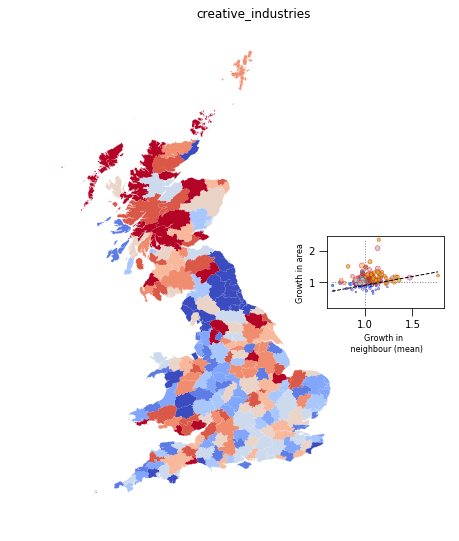

In [2062]:
fig,ax = plt.subplots(figsize=(7,9))
map_sector('creative_industries',ax,my_cmap='coolwarm')

creative_industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services


/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Museums, galleries and libraries
Design
Crafts


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


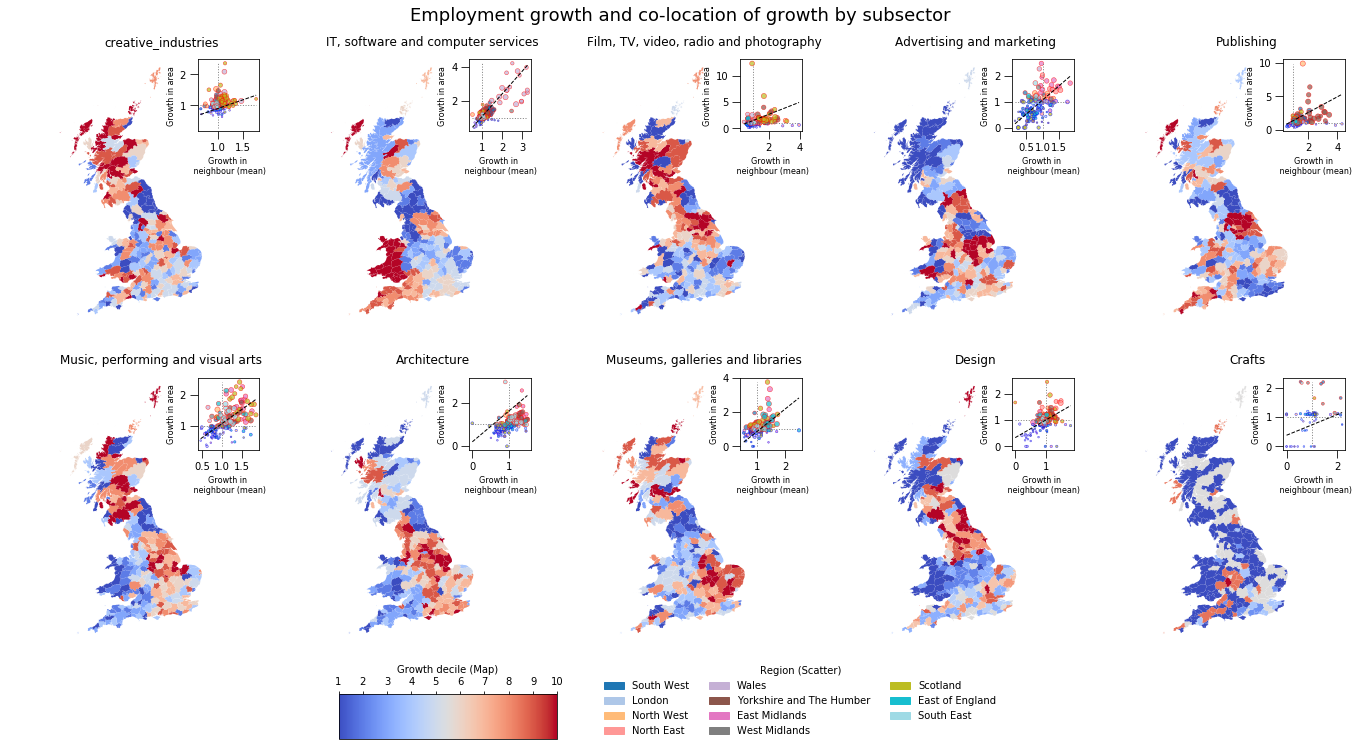

In [2000]:
fig,ax = plt.subplots(ncols=5,
                     nrows=2,figsize=(19,9))

for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<5 else num-5
    row = 0 if num<5 else 1
    
    map_sector(x,ax[row][col],my_cmap='coolwarm')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar
plt.subplots_adjust(hspace=0.01,wspace=0.01,bottom=0.6)

#Create the colorbar 
#Add axes
cbar_ax = fig.add_axes([0.25, -0.1, 0.16, 0.07])

#Add colorbar
norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Growth decile (Map)')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

fig.legend(handles=patches_reg,labels=regions,ncol=3,
           loc='lower center',
           bbox_to_anchor=(0.585,0.0082),title='Region (Scatter)',frameon=False)


fig.suptitle('Employment growth and co-location of growth by subsector',y=1.03,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_maps.pdf'.format(date_today=today_str),bbox_inches='tight')


In [2135]:
#Check what happens with the IDBR data?

bres_totals.loc[bres_totals['ttwa_name']=='York',:]

,ttwa_name,ttwa_code,Advertising and marketing,Architecture,Crafts,Design,"Film, TV, video, radio and photography","IT, software and computer services","Museums, galleries and libraries","Music, performing and visual arts",Publishing,not_in_sector,creative_industries,year
217,York,E30000294,980.0,350.0,15.0,220.0,195.0,2115.0,1100.0,505.0,140.0,159620.0,5620.0,2015
435,York,E30000294,390.0,475.0,5.0,300.0,605.0,2930.0,1075.0,705.0,295.0,158000.0,6780.0,2016


In [2038]:
geo_c =pd.read_excel(ext_data+'/geography_of_creativity_data.xlsx',sheetname=0) 

idbr = pd.read_excel(frontier_data+'/spd-creative clusters counts and LQs-06-11-2017.xlsx',sheetname=4)

In [2044]:
geo_c.loc[geo_c['TTWA']=='Cardiff']['2011_14_Software & digital_employment']

45    1796.5
Name: 2011_14_Software & digital_employment, dtype: float64

In [2127]:
idbr.loc[(idbr['TTWA name']=='Leeds') & (idbr['industry']=='IT, software and computer services'),:]

,industry,TTWA code,TTWA name,Number of enterprises,Turnover (£000),Employment,Total number of enterprises in area,Total turnover in area (£000),Total employment in area,Location quotient (number of enterprises),Location quotient (turnover),Location quotient (employment),Year
116,"IT, software and computer services",E30000229,Leeds,1545,823420,8870,31315,73168656,588940,0.95,0.85,0.9,2015
466,"IT, software and computer services",E30000229,Leeds,1665,737450,9090,33090,72193888,575060,0.95,0.70,0.9,2016


## Geographical concentration

Produce maps of concentration too?



In [3436]:
#We need to merge the 

all_lqs = pd.concat([bres_lqs.set_index(['ttwa_name','sector']),
                     idb_lqs.set_index(['ttwa_name','sector'])],axis=1).reset_index(drop=False)

all_lqs['region'] = [ttwa_region_lookup[x] for x in all_lqs['ttwa_name']]

#Create merged TTWA
ttwa_lqs_merged = pd.merge(ttwa_shp_read,
                       all_lqs.loc[
                           all_lqs.region!='Northern Ireland'],left_on='TTWA11NM',right_on='ttwa_name')

In [3437]:
def cluster_map(df,sector,variable_to_map,only_spec,my_cmap='coolwarm'):
    '''
    Creates a choropleth for a sector and variable.
    
    '''
    
    map_data = df.loc[df.sector==sector,:]
    
    
    #map_data = ttwa_merged.loc[ttwa_merged.sector==sector,:]
    
    #Quantise the employment change df
    #map_data['employment_change_q']= pd.qcut(map_data['employment_change'],
    #                                       q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    
    #Plot map
    map_data.plot(column=variable_to_map,
              ax=ax,cmap=my_cmap)
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    ax.set_title(sector,y=1.01,size=12)
    
    
    

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

cluster_map(ttwa_lqs_merged,)

## Sizebands and regional productivity

Change in size distributions by region and productivity

Create chart that lines up 

```
sizebands 2016    % increase vs 2015              % comparison with non-creative           % Productivity

% large               % large                       share of c emps / share all emps      % vs companies in same sband
% medium              % medium                                ...
% small               % small                      Or share of all emps in segment?
% micro               % micro

Stacked barchart     non-stacked barchart (+ / -)        depends on what I do               
```

**Tasks**

Create this df:

```
region / sizeband / businesses 2016 / businesses 2015 / share 2016 / share 2015 / % difference / % absolute difference
% all businesses in same size / share vs share in other sectors.

and another df with:
region / sizeband / productivity vs sector (we will need to lay down the ys to fit the categories in the first sizeband

```



* Create the creative industries regional df (includes 2016 and 2015, quantifies change between both)
* Create the 



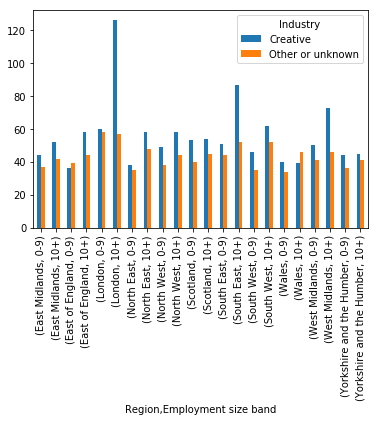

In [2126]:
#Changes in the size distribution

#Load GVA data from Frontier
gva = pd.read_excel(frontier_data+'/spd-GVA stats-15-11-2017v2.xlsx',sheetname=2)

pd.pivot_table(gva,index=['Region','Employment size band'],
                          columns='Industry',values='GVA per employee').plot.bar()


In [2999]:
#Business counts per sizeband/ region

#Sizebands
#Add region names
idbr_sizebands['region'] = [ttwa_region_lookup[x] for x in idbr_sizebands['ttwa_name']]

#Sum over regions for creative & non-creative sectors
idbr_regions_sizeb = idbr_sizebands.loc[[x in ['creative_industries','not_in_sector'] for x in idbr_sizebands.sector],
                                        ['sector','sizeband','value','year','region']].groupby([
    'region','sector','sizeband','year'])['value'].sum().reset_index(drop=False)

#Calculate the share of sizeband in total business by year and secor 

def get_share_over_variable(df,var,grouper,drop):
    '''
    
    #This function groups over all the other variables in the DF and returns the share of the variable in the total.
    #Grouper are the variables to group over, drop is a variable to drop
    
    '''
    
    #Drop the variable we don't want (in this case, it is the second year - which we don't want to group by
    #because then we get the shares over a single observation!)
    if drop!=None:
        df = df.drop(drop,axis=1)
    
    #Create variables to group over
    other_vars = [x for x in df.columns if x not in [var,grouper]]
    
    #Produce the share
    out = df.groupby(other_vars)[var].apply(lambda x: x/x.sum())
    
    #Out it comes
    return(out)


#Pivot to put the years into columns
piv = pd.pivot_table(idbr_regions_sizeb,index=[x for x in idbr_regions_sizeb.columns if x not in['year','value']],
                                       columns='year',values='value').reset_index(drop=False)

#Extract the share. NB we zip a list of years for which we want the shares and years which we want to drop
#from the analysis
#NB we are converting the years to financial (rather than nominal)
piv['sizeband_share_2015'],piv['sizeband_share_2016']  = [get_share_over_variable(piv,x,drop=y,
                                                                                   grouper='sizeband') 
                                                          for x,y in zip([2016,2017],[2017,2016])]

#Growth in the share of a sizeband between years
piv['sizeband_share_growth'] = piv['sizeband_share_2016']/piv['sizeband_share_2015']

#Absolute growth in the sizeband
piv['sizeband_abs_growth'] = piv[2017]-piv[2016]

#Compare share in ci vs share out
piv_comp = pd.pivot_table(piv[['region','sector','sizeband','sizeband_share_2016']],
                          index=['region','sizeband'],
                          columns='sector',values='sizeband_share_2016')

#How do the creative - non creative sizeband shares compare?
piv_comp['c_v_non_c_share'] = piv_comp['creative_industries']/piv_comp['not_in_sector']

piv_all = pd.concat([piv.loc[piv.sector=='creative_industries',:].set_index(['region','sizeband']),piv_comp],axis=1)

piv_final = piv_all.reset_index(drop=False)[['region','sizeband','sizeband_share_2016',
                                             'sizeband_share_growth','sizeband_abs_growth',
                                             'c_v_non_c_share']]
piv_final.fillna(1,inplace=True)

#Here is the thing
piv_final.head()

,region,sizeband,sizeband_share_2016,sizeband_share_growth,sizeband_abs_growth,c_v_non_c_share
0,East Midlands,Large (250+),0.000000,1.000000,0,0.000000
1,East Midlands,Medium-sized (50 to 249),0.004655,1.144120,10,0.195832
2,East Midlands,Micro (0 to 9),0.945832,0.999608,710,1.123473
3,East Midlands,Small (10 to 49),0.049513,0.995668,35,0.374709
4,East of England,Large (250+),0.000201,0.966432,0,0.124937


In [2402]:
sizeband_names_lookup = {x:x.split(" ")[0].lower() for x in set(piv_final.sizeband)}

piv_final['size_short'] = [sizeband_names_lookup[x] for x in piv_final.sizeband]

sizes_sorted = ['micro','small','medium-sized','large']

piv_final.head()

,region,sizeband,sizeband_share_2016,sizeband_share_growth,sizeband_abs_growth,c_v_non_c_share,size_short
0,East Midlands,Large (250+),0.000000,1.000000,0,0.000000,large
1,East Midlands,Medium-sized (50 to 249),0.004655,1.144120,10,0.195832,medium-sized
2,East Midlands,Micro (0 to 9),0.945832,0.999608,710,1.123473,micro
3,East Midlands,Small (10 to 49),0.049513,0.995668,35,0.374709,small
4,East of England,Large (250+),0.000201,0.966432,0,0.124937,large


In [2966]:
#Also transform productivities

gva_pivoted = pd.pivot_table(gva,index=['Region','Employment size band'],
                          columns='Industry',values='GVA per employee').reset_index(drop=False)
gva_pivoted['comp_prod'] = gva_pivoted['Creative']/ gva_pivoted['Other or unknown']

#Rename Yorkshire...
gva_pivoted['Region'] = [x if x.split(" ")[0]!='Yorkshire' else 'Yorkshire and The Humber' for x in gva_pivoted['Region']]

accent_colors = plt.cm.get_cmap('Dark2').colors[:4]


In [2967]:
ypos = [0.2,0.4,0.6,0.8]
ypositions_gva = [0.2,0.6]

In [2971]:
def plot_sizebands(region,ax,
                   
                   #Parameters for normal charts
                   colors=accent_colors,
                   df=piv_final,
                   sizepos=ypos,
                   
                   #Parameters for GVA
                   ypos_gva=ypositions_gva,
                   colors_gva=[accent_colors[0],'steelblue'],
                   gva_df = gva_pivoted,
                   
                   #Labelling
                   xlabels=False):
    '''
    This function returns a bunch of plots about a region sizebands
    
    '''
    
    #Select data and sort
    reg_data = df.loc[df.region==region,:].set_index('size_short').loc[
        sizes_sorted,:].reset_index(drop=False)
    
    #Create squares
    rects = squarify.squarify([x for x in reg_data.sizeband_share_2016 if x>0],0,0,1,1)
    
    #Draw a treemap with the shares
    for num_size,x in enumerate(rects):
        ax[0].add_patch(
            patches.Rectangle((rects[num_size]['x'],
                               rects[num_size]['y']),
                              rects[num_size]['dx'],
                              rects[num_size]['dy'],facecolor=colors[num_size],
                             edgecolor='white'))
    
    #Remove ticks and ticklabels
    #ax[0].xaxis.set_visible(False)
    
    ax[0].annotate(
        '{x}'.format(x="micro:\n"+
                     str(np.round(100*reg_data.sizeband_share_2016[0],1))+'%'),xy=(0.01,0.05),fontsize=16,color='white')
    
    
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_yticks([])
    ax[0].set_yticklabels([])

    #Set limits for Y
    ax[0].set_ylim((-0.05,1.05))
    
    
    #Name
    lab_name = " ".join([w if num!=2 else '\n'+w for num,w in enumerate(region.split(" "))])
    ax[0].set_ylabel(lab_name)

    
    #Loop through the sizebands for the other charts
    for num_2 in np.arange(len(reg_data)):
        
        #Extract values
        values = list(reg_data.iloc[num_2,[3,4,5,6]])
        
        #Draw the line chart
        change = 100*values[1]

        #Choose the location of the y axis = mean of bottom and top of the bar
        yp = sizepos[num_2]

        #Set limits for axes in the second one
        #ax[1].set_xlim((reg_data['sizeband_share_growth'].min()-1-0.2,
        #                reg_data['sizeband_share_growth'].max()-1+0.2))

        #Set limits of y axes
        ax[1].set_ylim((-0.1,1.1))

        #Draw line
        ax[1].plot([0,change-100],[yp,yp],
                   color=colors[num_2])

        #print(values[2])

        #Draw markets (another scatter!)
        ax[1].scatter(x=change-100,y=yp,
                      s=20*np.log(np.abs(values[2]+0.000001)),
                      #1000,
                      alpha=0.4,
                      edgecolor='red' if values[2]>0 else ['blue'],
                      color=colors[num_2])

        #More play with axes etc
        ax[1].set_yticks([])

        ax[1].vlines(x=0,ymin=0,ymax=1,linestyle=':',linewidth=0.6)

        ax[1].yaxis.set_visible(False)
        
        #Reset bottom
        #bot=bot+share

        #Rest of economy
        ax[2].set_ylim((-0.1,1.1))
        ax[2].set_xlim((100*reg_data['c_v_non_c_share'].min()-10,
                        100*reg_data['c_v_non_c_share'].max()+10))


        ax[2].set_yticks([])


        vs_other = 100*values[3]

        ax[2].plot([0,vs_other],[yp,yp],
                   color=colors[num_2])
        ax[2].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
        
        #Also extract mean size shares for UK
    
    #This extracts the UK mean for comparison
    for num,x in enumerate(sizes_sorted):
        uk_mean = 100*df.loc[df.size_short==x,'c_v_non_c_share'].mean()
        #print(uk_mean)
        ax[2].scatter(x=uk_mean,y=ypos[num],
                      #ymax=0.1,linestyle='-',linewidth=1.5,
                      color='darkgrey',s=15,marker='s',facecolors='none')
        
    
    #And finally... the productivities!
    #Calculate mean productivities 

    gva_means = list(gva_df.groupby('Employment size band')['Creative'].mean())
    gva_comp_means = list(100*gva_df.groupby('Employment size band')['comp_prod'].mean())

    #Extract the regional productivity
    reg_gva = gva_pivoted.loc[gva_pivoted.Region==region,:]
    
    #Go through the two sizebands we have 
    for num_3,emp in enumerate(set(reg_gva['Employment size band'])):
        
        #Extract the comparative and absolute GVA values
        
        gva_comp = 100*reg_gva.iloc[num_3,:]['comp_prod']
        gva_abs = reg_gva.iloc[num_3,:]['Creative']
        
        
        #Plot lines
        ax[3].plot([0,gva_comp],[ypos_gva[num_3],ypos_gva[num_3]],c=colors_gva[num_3])
        
        #Plot circles (including the actual value and the mean)
        ax[3].scatter(x=gva_comp,y=ypos_gva[num_3],s=gva_abs,alpha=0.8,c=colors_gva[num_3])
        
        ax[3].scatter(x=gva_comp_means[num_3],y=ypos_gva[num_3],s=gva_means[num_3],
                      facecolors='none',edgecolor='darkgrey')
        
    ax[3].set_ylim((-0.1,1.1))
    
    ax[3].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
    
    
    #Some label gubbins at the end
    ax[1].yaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    if xlabels!=False:
        ax[0].set_xlabel('Sizeband as \n share of total',size=9)
        ax[1].set_xlabel('Growth in sizeband \n (% and total)',size=9)
        ax[2].set_xlabel('Importance of sizeband \n (vs other sectors)',size=9)
        ax[3].set_xlabel('GVA per worker \n (vs other sectors)',size=9)


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


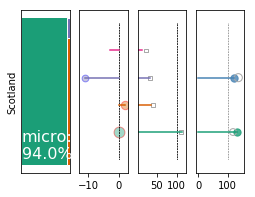

In [2972]:
fig,ax = plt.subplots(figsize=(4,3),ncols=4)

plot_sizebands('Scotland',ax)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


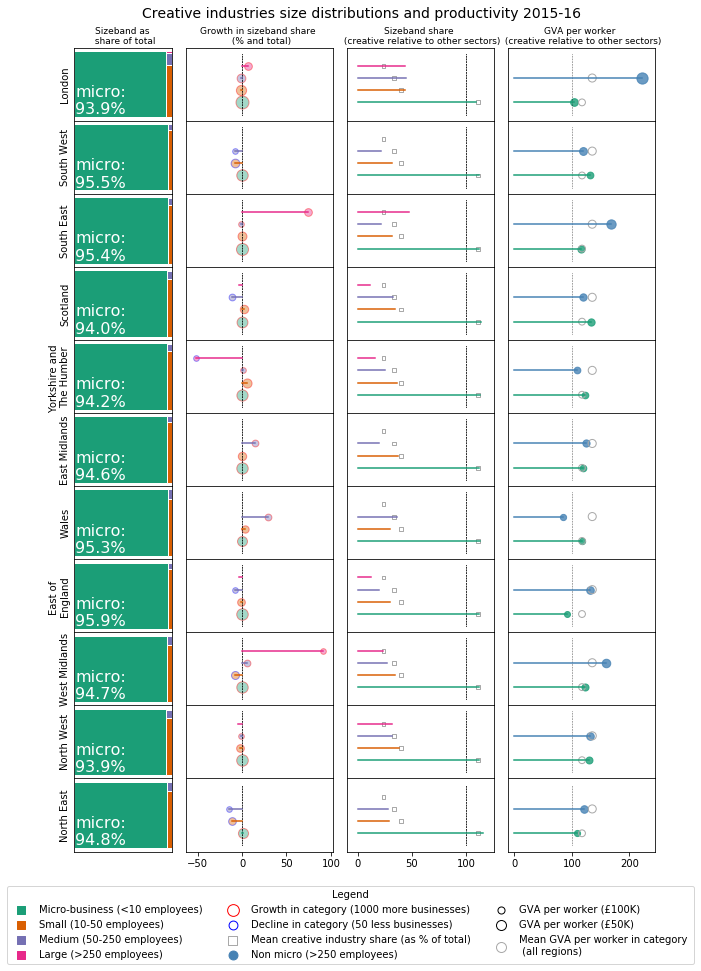

In [2976]:
fig,ax = plt.subplots(figsize=(9,12),nrows=len(regions_sorted),ncols=4,sharex='col',
                     gridspec_kw={'width_ratios':[2,3,3,3]}
                     )

for num,x in enumerate(reversed(regions_sorted)):
    plot_sizebands(x,ax[num])
    
    #Remove titles and axes for all charts except the last one
    

#ax[len(regions_sorted)-1][0].set_xlabel('Sizeband as \n share of total',size=9)
#ax[len(regions_sorted)-1][1].set_xlabel('Growth in sizeband share \n (% and total)',size=9)
#ax[len(regions_sorted)-1][2].set_xlabel('Sizeband share \n (creative relative other sectors)',size=9)
#ax[len(regions_sorted)-1][3].set_xlabel('GVA per worker \n (creative relative other sectors)',size=9)

ax[0][0].set_xlabel('Sizeband as \n share of total',size=9)
ax[0][1].set_xlabel('Growth in sizeband share \n (% and total)',size=9)
ax[0][2].set_xlabel('Sizeband share \n (creative relative to other sectors)',size=9)
ax[0][3].set_xlabel('GVA per worker \n (creative relative to other sectors)',size=9)




for x in np.arange(0,4):
    ax[0][x].xaxis.set_label_position('top')



plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0)


#Add custom legend with some invisible scatters
#Sizez
mic = plt.scatter([],[], s=80, marker='s',color=accent_colors[0])
sm = plt.scatter([],[], s=80, marker='s',color=accent_colors[1])
med = plt.scatter([],[], s=80, marker='s',color=accent_colors[2])
lar = plt.scatter([],[], s=80, marker='s',color=accent_colors[3])

#Growth and decline
size_gr = plt.scatter([],[], s=20*np.log(1000), marker='o',color='white',edgecolor='red') 
size_decl = plt.scatter([],[], s=20*np.log(50), marker='o',color='white',edgecolor='blue') 

#Size shares
avg_share = plt.scatter([],[],s=80, marker='s',facecolors='none',color='darkgrey')

#Productivities
non_micro = plt.scatter([],[],s=80, marker='o',color='steelblue')
gva_pw_1 = plt.scatter([],[],s=50, marker='o',color='black',facecolors='white')
gva_pw_2 = plt.scatter([],[],s=100, marker='o',color='black',facecolors='white')
avg_size = plt.scatter([],[],s=100, marker='o',color='darkgrey',facecolors='white')




empty = plt.scatter([],[],s=80, marker='o',color='white',edgecolor='white')


circles_h, circles_l = ax[len(regions_sorted)-1][1].get_legend_handles_labels()

#ax[len(regions_sorted)-1][1].legend()


#ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
plt.legend((mic,sm,med,lar,
            size_gr,size_decl,avg_share,non_micro,gva_pw_1,gva_pw_2,avg_size),
           ('Micro-business (<10 employees)', 
            'Small (10-50 employees)', 
            'Medium (50-250 employees)',
            'Large (>250 employees)',
            'Growth in category (1000 more businesses)',
            'Decline in category (50 less businesses)',
            'Mean creative industry share (as % of total)',
            'Non micro (>250 employees)',
            'GVA per worker (£100K)',
            'GVA per worker (£50K)',
            'Mean GVA per worker in category \n (all regions)',),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(1.3,-0.4),ncol=3,fontsize=10)  



fig.suptitle('Creative industries size distributions and productivity 2015-16',y=1.01,fontsize=14)

plt.savefig(fig_path+'/{date}.sizebands.pdf'.format(date=today_str),bbox_inches='tight')


# Survival rates and growth dynamics

**Actions**

* Descriptive analysis visualisation will require

``` 
Gdyn

TTWA \\ Type of change \\ Employment change (period 1) \\ Employment change (share of total)  \\ Employment change (period 1 vs period 2) \\ Surv rate

```




* Create a DF for EDA:

```
Micro-rate \\ Large firm share \\ Employment diversity \\ Business diversity \\ Survival rates \\ 
\\ Employment growth \\ Business growth \\ Specialisation growth \\ Diversification (#sectors with 
specialisation gains) \\ Number of sectors with business + employment specialisation gains
Growth dynamics (% of jobs created by large comps) \\ Churn \\ Company stability 

```

* Create heatmap and correlate
* Based on this, opt for charts to explore

** Some hypotheses to explore**

* More diverse / churny locations grow faster / have more employment growth due to hgfs
* More diverse locations gain specialisation in more sectors
* Locations with more microbusinesses are churnier
* Locations with more large firms are more stable



In [2993]:
gdyn_ttwa = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheetname=7)
surv_ttwa = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC (1).xlsx',sheetname=3)

In [3003]:
#Process growth dynamics

#Label with TTWA
gdyn_ttwa['ttwa_name'] = [ttwa_name_lookup[x] if x in ttwa_name_lookup.keys() else np.nan for x in gdyn_ttwa.ttwa ]

#Select relevant vars

gdyn_sel = gdyn_ttwa[['ttwa_name','bandemployment','cohort','d_employment','entref','industry']]
gdyn_sel['dir'] = ['grow' if x in ['birth','bl10inc','bv10logr','hgr'] 
                   else 'stable' if x in ['bl10sm'] else 'decline' for x in gdyn_sel['bandemployment']]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3012]:
#Calculate shares

#Share of businesses
gdyn_sel['biz_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry'])['entref'].apply(lambda x: x/x.sum())

gdyn_sel['emp_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry','dir'])[
    'd_employment'].apply(lambda x: np.abs(x)/x.sum())



/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3047]:
#A bit more munging
#Focus only on the most recent cohort

gdyn_sel_recent = gdyn_sel.loc[(gdyn_sel.cohort=='201013-201316') & 
                               ([x in ['All creative','Other'] for x in gdyn_sel.industry]),:].drop('cohort',axis=1)

#Reshape to normalise creative vs other sectors
gdyn_comps = pd.pivot_table(gdyn_sel_recent,index=['ttwa_name','bandemployment'],
                            columns='industry',values=['emp_share','biz_share']).reset_index(drop=False)

#Change names of columns (multi-index)
gdyn_comps.columns = ["_".join(col) for col in gdyn_comps.columns]

#Create new column
gdyn_comps['creative_emp_vs_other'] = gdyn_comps['emp_share_All creative']/ gdyn_comps['emp_share_Other']

#Merge everything
gdyn_merged = pd.merge(gdyn_sel_recent.loc[gdyn_sel_recent.industry=='All creative'],
                       gdyn_comps,
                       left_on=['ttwa_name','bandemployment'],
                       right_on=['ttwa_name_','bandemployment_'])[
    ['ttwa_name','bandemployment','d_employment','entref','biz_share','emp_share','creative_emp_vs_other']]

In [3257]:
#Create a jobs creation var (also for sorting)

ttwa_emp_growth = gdyn_merged.groupby('ttwa_name')['d_employment'].sum().sort_values(ascending=False)

my_ttwas = [x for x in ttwa_emp_growth.index if x in ttwa_is_cluster + ['Birmingham']]
                                                                        #'Huddersfield']]


#Subset by its ttwa
gdyn_merged_cluster = gdyn_merged.loc[[x in ttwa_is_cluster+['Birmingham']
                                                             #'Huddersfield'] 
                                       for x in gdyn_merged.ttwa_name],:]

gdyn_merged_cluster.fillna(0,inplace=True)


#Some preps

#sort categories based on the levels of growth they create
bands_biz = gdyn_merged_cluster.groupby('bandemployment')['emp_share'].mean().sort_values(ascending=False)

#Color palette
bar_cols = plt.matplotlib.cm.get_cmap('Set3').colors[:8]

bands_biz_negs = list(bands_biz.index[bands_biz<0])
band_biz_pos = list(bands_biz.index[bands_biz>0])

surv_long = pd.melt(surv,id_vars=['ttwa','industry'])
surv_long['ttwa_name'] = [ttwa_name_lookup[x] for x in surv_long.ttwa]

surv_sel = pd.pivot_table(surv_long.loc[[x in my_ttwas for x in surv_long.ttwa_name] and 
                        ['rate' in x for x in surv_long.variable],:],
                          index=['ttwa_name','variable'],columns='industry',values='value').reset_index(drop=False)




/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [3331]:
regions_sorted_2

['London',
 'South West',
 'South East',
 'Scotland',
 'Yorkshire and The Humber',
 'East Midlands',
 'Wales',
 'East of England',
 'West Midlands',
 'North West',
 'North East',
 'Northern Ireland']

In [3333]:
regions_sorted_2 = regions_sorted[::-1]+['Northern Ireland']

my_ttwas_sorted_2 = [x[0] for x in sorted([[x,ttwa_region_lookup[x],
                           regions_sorted_2.index(ttwa_region_lookup[x])] for x in my_ttwas],key=lambda x: x[2])]

my_ttwas_sorted_2

['London',
 'Slough and Heathrow',
 'Bristol',
 'Bournemouth',
 'Reading',
 'Oxford',
 'Brighton',
 'Guildford and Aldershot',
 'High Wycombe and Aylesbury',
 'Milton Keynes',
 'Medway',
 'Tunbridge Wells',
 'Eastbourne',
 'Southampton',
 'Newbury',
 'Edinburgh',
 'Glasgow',
 'Leeds',
 'Sheffield',
 'Harrogate',
 'Northampton',
 'Cardiff',
 'Luton',
 'Cambridge',
 'Colchester',
 'Norwich',
 'Chelmsford',
 'Peterborough',
 'Birmingham',
 'Leamington Spa',
 'Manchester',
 'Crewe',
 'Chester',
 'Liverpool',
 'Warrington and Wigan',
 'Newcastle',
 'Middlesbrough and Stockton',
 'Belfast']

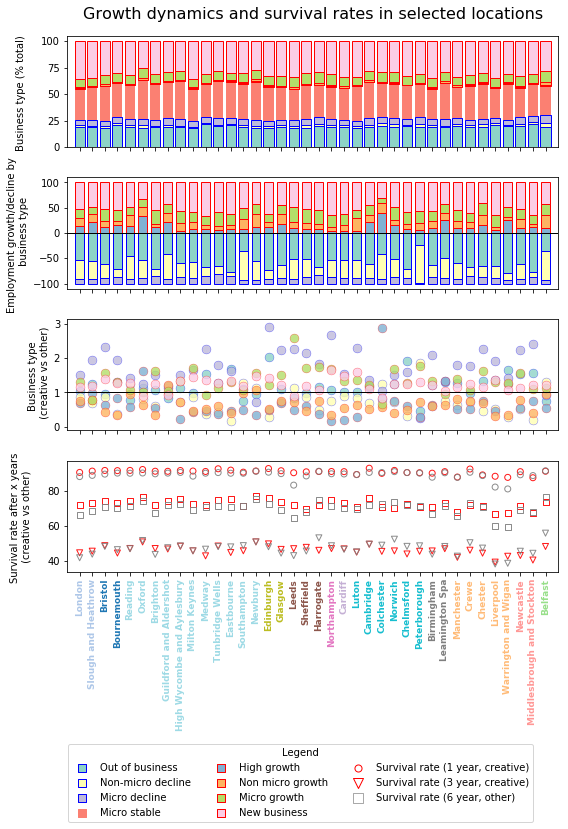

In [3404]:
#Draw plot
fig,ax = plt.subplots(figsize=(8,10),nrows=4,sharex=True)

#Loop over TTWAs
for num,ttwa in enumerate(my_ttwas_sorted_2):
    
    #Subset
    ttwa_data = gdyn_merged_cluster.loc[gdyn_merged_cluster.ttwa_name==ttwa,:]
    
    #Bottom for bars
    bot_biz = 0
    bottom_decl=0
    bottom_gr=0
    
    for num_2,sizeb in enumerate(reversed(bands_biz.index)):
        
        #Business growth share
        value_biz=100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'biz_share'])
        #print(value)
        ax[0].bar(left=num,height=value_biz,width=0.8,bottom=bot_biz,
               color=bar_cols[num_2],
               edgecolor='red' if sizeb in band_biz_pos else 'blue' if sizeb in bands_biz_negs else None)
        
        bot_biz = bot_biz+value_biz
        
        #Employment value
        value_emp = 100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'emp_share'])
        
        #Plot upwards if the sizeband is positive, downwards if the sizeband is negative
        if sizeb in list(bands_biz_negs):
            ax[1].bar(left=num,height =value_emp,width=0.7,bottom=bottom_decl,color=bar_cols[num_2],
                     edgecolor='blue')
            bottom_decl = bottom_decl + value_emp
            
        if sizeb in list(band_biz_pos):
            ax[1].bar(left=num,height =value_emp,width=0.7,bottom=bottom_gr,color=bar_cols[num_2],
                     edgecolor='red')
            bottom_gr = bottom_gr + value_emp
        
        #Draw horizontal line
        ax[1].hlines(y=0,xmin=-1,xmax=len(my_ttwas)+0.5,linewidth=1)
    
    
        #Compared with rest of economy
        value_comparison = float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'creative_emp_vs_other'])
        
        #print(value_comparison)
        
        if sizeb in band_biz_pos+bands_biz_negs:
            ax[2].scatter(x=num,y=value_comparison,color=bar_cols[num_2],s=80,
                          #edgecolor=bar_cols[num_2],alpha=0.7)
                          edgecolor='red' if sizeb in band_biz_pos else 'blue',linewidth=0.3,alpha=0.8)
    
        ax[2].hlines(y=1,xmin=-1,xmax=len(my_ttwas)+0.5,linewidth=1)
    
    
        
        
        #Survivals
    surv_ttwa = surv_sel.loc[surv_sel.ttwa_name==ttwa,:]
        
    for y in ['surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']:
        surv_cr= 100*float(surv_ttwa.loc[surv_ttwa.variable==y,'Creative'])
        surv_other= 100*float(surv_ttwa.loc[surv_ttwa.variable==y,'Other or unknown'])
        
            #print(surv_cr)
        
        if '1' in y:
            my_marker = 'o'
            
        if '3' in y:
            my_marker = 's'
            
        if '6' in y:
            my_marker = 'v'
        
        
        ax[3].scatter(x=num,y=surv_cr,marker=my_marker,color='red',alpha=0.9,facecolors='none')
        ax[3].scatter(x=num,y=surv_other,marker=my_marker,color='grey',alpha=0.9,facecolors='none')
        
    ax[3].set_xticks([x for x in np.arange(0,len(my_ttwas))])
    ax[3].set_xticklabels(my_ttwas_sorted_2,rotation=90,
                              #ha='right'
                          size=9)


#Label titles
ax[0].set_ylabel('Business type (% total) \n')
ax[1].set_ylabel('Employment growth/decline by \n business type')
ax[2].set_ylabel('Business type \n (creative vs other)')
ax[3].set_ylabel('Survival rate after x years \n (creative vs other) \n')
    

#Some final customisation
[ax[num].set_xlim(-1,len(my_ttwas_sorted_2)) for num in [0,1,2,3]]        

#Customise labels
[tick.set_color(regions_colors[ttwa_region_lookup[name]]) for name,tick in zip(my_ttwas_sorted_2,
                                                                            ax[3].xaxis.get_ticklabels())]

#Set xticklabels bold (to make them easier to read)
ax[3].set_xticklabels(ax[3].get_xticklabels(),{'weight':'bold'})

#Legends
#Add custom legend with some invisible scatters
#Performance

death = plt.scatter([],[], s=80, marker='s',color=bar_cols[0],edgecolor='blue')
bv10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[1],edgecolor='blue')
bl10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[2],edgecolor='blue')
bl10sm = plt.scatter([],[], s=80, marker='s',color=bar_cols[3])
hgr = plt.scatter([],[], s=80, marker='s',color=bar_cols[4],edgecolor='red')
bv10logr = plt.scatter([],[], s=80, marker='s',color=bar_cols[5],edgecolor='red')
bl10inc = plt.scatter([],[], s=80, marker='s',color=bar_cols[6],edgecolor='red')
birth = plt.scatter([],[], s=80, marker='s',color=bar_cols[7],edgecolor='red')

#Survival
surv_1 = plt.scatter([],[],s=50, marker='o',color='red',facecolors='white')
surv_3 = plt.scatter([],[],s=100, marker='v',color='red',facecolors='white')
surv_5 = plt.scatter([],[],s=100, marker='s',color='darkgrey',facecolors='white')


#Add legend
plt.legend((death, bv10dec, bl10dec, bl10sm, hgr, bv10logr, bl10inc, birth,surv_1,surv_3,surv_5),
           ('Out of business','Non-micro decline','Micro decline','Micro stable','High growth','Non micro growth',
           'Micro growth','New business','Survival rate (1 year, creative)',
            'Survival rate (3 year, creative)','Survival rate (6 year, other)'),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(0.96,-1.5),ncol=3,fontsize=10)  

plt.subplots_adjust(hspace=0.04)

plt.tight_layout()

fig.suptitle('Growth dynamics and survival rates in selected locations',y=1.02,x=0.55,size=16)

plt.savefig(fig_path+'/{date}_growth_dynamics.pdf'.format(date=today_str),bbox_inches='tight')

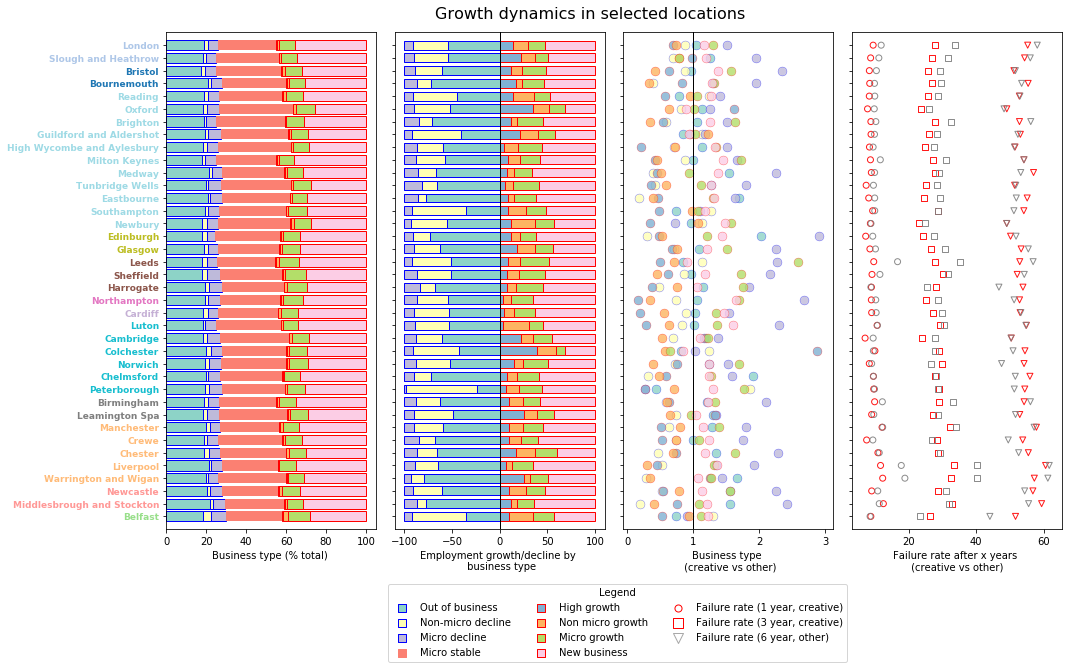

In [3427]:
#Draw plot
fig,ax = plt.subplots(figsize=(15,8),ncols=4,sharey=True)

#Loop over TTWAs
for num,ttwa in enumerate(reversed(my_ttwas_sorted_2)):
    
    #Subset
    ttwa_data = gdyn_merged_cluster.loc[gdyn_merged_cluster.ttwa_name==ttwa,:]
    
    #Bottom for bars
    bot_biz = 0
    bottom_decl=0
    bottom_gr=0
    
    for num_2,sizeb in enumerate(reversed(bands_biz.index)):
        
        #Business growth share
        value_biz=100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'biz_share'])
        #print(value)
        ax[0].barh(bottom=num,width=value_biz,height=0.8,left=bot_biz,
               color=bar_cols[num_2],
               edgecolor='red' if sizeb in band_biz_pos else 'blue' if sizeb in bands_biz_negs else None)
        
        bot_biz = bot_biz+value_biz
        
        #Employment value
        value_emp = 100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'emp_share'])
        
        #Plot upwards if the sizeband is positive, downwards if the sizeband is negative
        if sizeb in list(bands_biz_negs):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_decl,color=bar_cols[num_2],
                     edgecolor='blue')
            bottom_decl = bottom_decl + value_emp
            
        if sizeb in list(band_biz_pos):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_gr,color=bar_cols[num_2],
                     edgecolor='red')
            bottom_gr = bottom_gr + value_emp
        
        #Draw horizontal line
        ax[1].vlines(x=0,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        #Compared with rest of economy
        value_comparison = float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'creative_emp_vs_other'])
        
        #print(value_comparison)
        
        if sizeb in band_biz_pos+bands_biz_negs:
            ax[2].scatter(y=num,x=value_comparison,color=bar_cols[num_2],s=80,
                          #edgecolor=bar_cols[num_2],alpha=0.7)
                          edgecolor='red' if sizeb in band_biz_pos else 'blue',linewidth=0.3,alpha=0.8)
    
        ax[2].vlines(x=1,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        
        
        #Survivals
    surv_ttwa = surv_sel.loc[surv_sel.ttwa_name==ttwa,:]
        
    for y in ['surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']:
        surv_cr= 100-100*float(surv_ttwa.loc[surv_ttwa.variable==y,'Creative'])
        surv_other= 100-100*float(surv_ttwa.loc[surv_ttwa.variable==y,'Other or unknown'])
        
            #print(surv_cr)
        
        if '1' in y:
            my_marker = 'o'
            
        if '3' in y:
            my_marker = 's'
            
        if '6' in y:
            my_marker = 'v'
        
        
        ax[3].scatter(y=num,x=surv_cr,marker=my_marker,color='red',alpha=0.9,facecolors='none')
        ax[3].scatter(y=num,x=surv_other,marker=my_marker,color='grey',alpha=0.9,facecolors='none')
        
    ax[0].set_yticks(np.arange(0,len(my_ttwas)))
    ax[0].set_yticklabels(my_ttwas_sorted_2[::-1],
                          #rotation=90,
                              #ha='right'
                          size=9)


#Label titles
ax[0].set_xlabel('Business type (% total) \n')
ax[1].set_xlabel('Employment growth/decline by \n business type')
ax[2].set_xlabel('Business type \n (creative vs other)')
ax[3].set_xlabel('Failure rate after x years \n (creative vs other) \n')
    

#Some final customisation
[ax[num].set_ylim(-1,len(my_ttwas_sorted_2)) for num in [0,1,2,3]]        

#Customise labels
[tick.set_color(regions_colors[ttwa_region_lookup[name]]) for name,tick in zip(my_ttwas_sorted_2[::-1],
                                                                            ax[0].yaxis.get_ticklabels())]

#Set xticklabels bold (to make them easier to read)
ax[0].set_yticklabels(ax[0].get_yticklabels(),{'weight':'bold'})

#Legends
#Add custom legend with some invisible scatters
#Performance

death = plt.scatter([],[], s=80, marker='s',color=bar_cols[0],edgecolor='blue')
bv10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[1],edgecolor='blue')
bl10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[2],edgecolor='blue')
bl10sm = plt.scatter([],[], s=80, marker='s',color=bar_cols[3])
hgr = plt.scatter([],[], s=80, marker='s',color=bar_cols[4],edgecolor='red')
bv10logr = plt.scatter([],[], s=80, marker='s',color=bar_cols[5],edgecolor='red')
bl10inc = plt.scatter([],[], s=80, marker='s',color=bar_cols[6],edgecolor='red')
birth = plt.scatter([],[], s=80, marker='s',color=bar_cols[7],edgecolor='red')

#Survival
surv_1 = plt.scatter([],[],s=50, marker='o',color='red',facecolors='white')
surv_3 = plt.scatter([],[],s=100, marker='s',color='red',facecolors='white')
surv_5 = plt.scatter([],[],s=100, marker='v',color='darkgrey',facecolors='white')


#Add legend
plt.legend((death, bv10dec, bl10dec, bl10sm, hgr, bv10logr, bl10inc, birth,surv_1,surv_3,surv_5),
           ('Out of business','Non-micro decline','Micro decline','Micro stable','High growth','Non micro growth',
           'Micro growth','New business','Failure rate (1 year, creative)',
            'Failure rate (3 year, creative)','Failure rate (6 year, other)'),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(0,-0.1),ncol=3,fontsize=10)  

plt.subplots_adjust(wspace=0.04)

plt.tight_layout()

fig.suptitle('Growth dynamics in selected locations',y=1.02,x=0.55,size=16)

plt.savefig(fig_path+'/{date}_growth_dynamics_hor.pdf'.format(date=today_str),bbox_inches='tight')

In [3411]:
?plt.barh